**Import Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd 
import numpy as np  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, classification_report  
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBRegressor  
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam, RMSprop 
from tensorflow.keras.regularizers import l2 
import seaborn as sns 
import matplotlib.pyplot as plt 
import joblib  

I loaded the three datasets (fulfilment_center_info.csv, meal_info.csv, and train.csv) and explore their structure.

In [2]:
# Load datasets
fulfillment_data = pd.read_csv('Dataset/fulfilment_center_info.csv')
meal_data = pd.read_csv('Dataset/meal_info.csv')
train_data = pd.read_csv('Dataset/train.csv')

# Display basic information
print("Fulfillment Center Info:")
print(fulfillment_data.head())

print("\nMeal Info:")
print(meal_data.head())

print("\nTrain Data:")
print(train_data.head())

Fulfillment Center Info:
   center_id  city_code  region_code center_type  op_area
0         11        679           56      TYPE_A      3.7
1         13        590           56      TYPE_B      6.7
2        124        590           56      TYPE_C      4.0
3         66        648           34      TYPE_A      4.1
4         94        632           34      TYPE_C      3.6

Meal Info:
   meal_id   category cuisine
0     1885  Beverages    Thai
1     1993  Beverages    Thai
2     2539  Beverages    Thai
3     1248  Beverages  Indian
4     2631  Beverages  Indian

Train Data:
        id  week  center_id  meal_id  checkout_price  base_price  \
0  1379560     1         55     1885          136.83      152.29   
1  1466964     1         55     1993          136.83      135.83   
2  1346989     1         55     2539          134.86      135.86   
3  1338232     1         55     2139          339.50      437.53   
4  1448490     1         55     2631          243.50      242.50   

   emailer_fo

**Merge and Preprocess the Data**

In [ ]:
# Merge datasets
merged_data = train_data.merge(fulfillment_data, on='center_id', how='left')
merged_data = merged_data.merge(meal_data, on='meal_id', how='left')

# Handle missing values (if any)
merged_data.fillna(0, inplace=True)

# Encode categorical variables
merged_data = pd.get_dummies(merged_data, columns=['center_type', 'category', 'cuisine'], drop_first=True)

# Define features and target
X = merged_data.drop(columns=['id', 'num_orders'])  
y = merged_data['num_orders']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

I splitted the data into training, validation, and test sets.

In [4]:
# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Display the shapes of the splits
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Training set: (319583, 28), (319583,)
Validation set: (68482, 28), (68482,)
Test set: (68483, 28), (68483,)


**Define Helper Functions**

In [ ]:
def define_model(optimizer='Adam', regularizer=None, dropout=0.0, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizer, input_shape=(X_train.shape[1],)))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
    if dropout > 0:
        model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))

    # Compile the model
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'RMSprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer")

    model.compile(optimizer=opt, loss='mean_squared_error', metrics=['mae'])
    return model

In [6]:
# Define a function to plot the loss curve
def loss_curve_plot(history):
    epochs = range(1, len(history.history['loss']) + 1)
    plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

**Train and Evaluate Models**

We train and evaluate the following models:
Logistic Regression, Simple Neural Network (No Optimization), Neural Network with Dropout, Neural Network with Dropout and L2 Regularization, Neural Network with Early Stopping, XGBoost.

In [7]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_log_reg = log_reg.predict(X_val)
print("Logistic Regression Metrics:")
print(f"Mean Squared Error: {mean_squared_error(y_val, y_pred_log_reg)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_val, y_pred_log_reg)}")
print(f"R2 Score: {r2_score(y_val, y_pred_log_reg)}")

Logistic Regression Metrics:
Mean Squared Error: 103482.94547472328
Mean Absolute Error: 141.65985222394207
R2 Score: 0.34595032738801534


c:\Users\tochi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step - loss: 92413.3750 - mae: 145.0110 - val_loss: 62224.4688 - val_mae: 116.8600
Epoch 2/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 60752.3477 - mae: 117.0942 - val_loss: 54826.4336 - val_mae: 112.0018
Epoch 3/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - loss: 52175.8555 - mae: 111.2791 - val_loss: 51527.7344 - val_mae: 106.7571
Epoch 4/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step - loss: 48852.5742 - mae: 107.6457 - val_loss: 48115.6641 - val_mae: 103.9675
Epoch 5/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 51s 5ms/step - loss: 46236.6914 - mae: 104.4963 - val_loss: 45784.3086 - val_mae: 100.4230
Epoch 6/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - loss: 45372.5039 - mae: 102.7186 - val_loss: 45560.4180 - val_mae: 104.6578
Epoch 7/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 44242.7422 - mae: 100.0883 - val_loss: 41367.3711 - val_mae: 97.0552
Epoch 8/10
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 45210.0

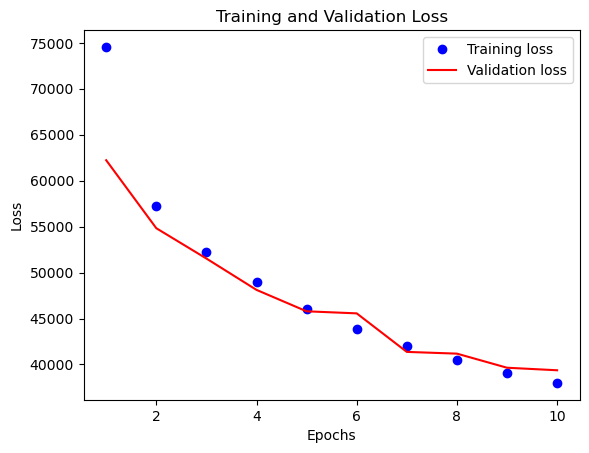

In [8]:
# Train a simple neural network
model_simple = define_model(optimizer='Adam', regularizer=None, dropout=0.0, learning_rate=0.001)
history_simple = model_simple.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=32)
loss_curve_plot(history_simple)

Epoch 1/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 92879.6562 - mae: 148.3229 - val_loss: 68279.7031 - val_mae: 126.3058
Epoch 2/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 73368.6953 - mae: 125.0962 - val_loss: 60473.1289 - val_mae: 115.2485
Epoch 3/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 60493.5352 - mae: 120.3745 - val_loss: 55706.2227 - val_mae: 112.1457
Epoch 4/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 63949.3438 - mae: 118.6653 - val_loss: 54776.4766 - val_mae: 108.9539
Epoch 5/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 56745.6016 - mae: 116.6787 - val_loss: 52549.0391 - val_mae: 109.5107
Epoch 6/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 57594.1250 - mae: 116.2358 - val_loss: 49739.8047 - val_mae: 104.8044
Epoch 7/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 55084.3945 - mae: 113.8229 - val_loss: 48686.1367 - val_mae: 104.7040
Epoch 8/20
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 54670.

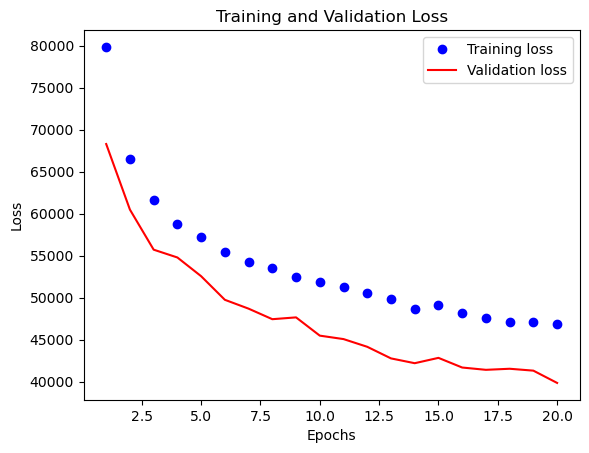

In [9]:
# Train a neural network with dropout
model_dropout = define_model(optimizer='Adam', regularizer=None, dropout=0.3, learning_rate=0.001)
history_dropout = model_dropout.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)
loss_curve_plot(history_dropout)

Epoch 1/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 92240.7500 - mae: 146.8525 - val_loss: 67060.7422 - val_mae: 118.7920
Epoch 2/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - loss: 64186.9062 - mae: 124.1782 - val_loss: 59684.0430 - val_mae: 116.2650
Epoch 3/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 59511.8594 - mae: 119.7675 - val_loss: 55246.1289 - val_mae: 109.6136
Epoch 4/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 57002.2344 - mae: 116.5962 - val_loss: 52571.2969 - val_mae: 108.2721
Epoch 5/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 54603.5586 - mae: 115.9194 - val_loss: 52186.5000 - val_mae: 105.6459
Epoch 6/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 57701.3086 - mae: 115.3290 - val_loss: 51557.0195 - val_mae: 104.4397
Epoch 7/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 53232.2031 - mae: 113.8283 - val_loss: 48418.7695 - val_mae: 106.1335
Epoch 8/30
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 53151.

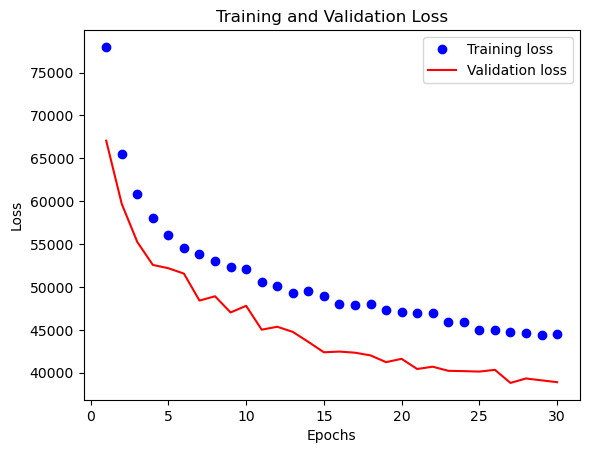

In [10]:
# Train a neural network with dropout and L2 regularization
model_dropout_l2 = define_model(optimizer='Adam', regularizer=l2(0.01), dropout=0.3, learning_rate=0.001)
history_dropout_l2 = model_dropout_l2.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), batch_size=32)
loss_curve_plot(history_dropout_l2)

Epoch 1/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 16s 1ms/step - loss: 92646.8750 - mae: 147.8974 - val_loss: 67748.2109 - val_mae: 119.6841
Epoch 2/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 68531.4219 - mae: 125.6033 - val_loss: 61238.1758 - val_mae: 114.7555
Epoch 3/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 63536.1016 - mae: 121.3713 - val_loss: 57061.8711 - val_mae: 110.6783
Epoch 4/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 60664.6133 - mae: 118.0709 - val_loss: 53738.6523 - val_mae: 107.6970
Epoch 5/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 54813.6133 - mae: 115.8791 - val_loss: 51141.0664 - val_mae: 107.8103
Epoch 6/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 56461.4375 - mae: 115.2627 - val_loss: 51682.0430 - val_mae: 103.1245
Epoch 7/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 58627.3438 - mae: 114.3710 - val_loss: 48734.2852 - val_mae: 102.8755
Epoch 8/50
9987/9987 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step - loss: 52844.

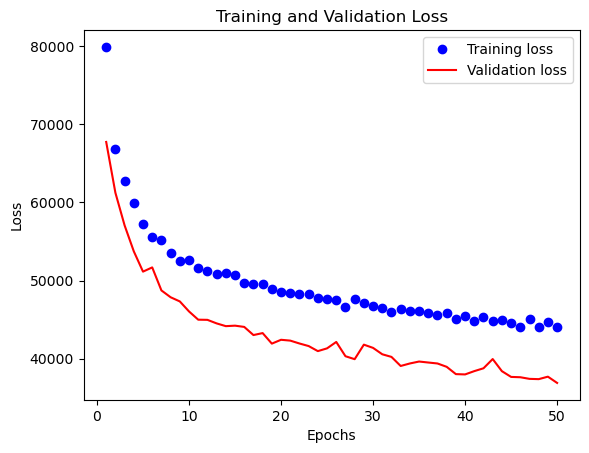

In [11]:
# Train a neural network with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_early_stopping = define_model(optimizer='Adam', regularizer=l2(0.01), dropout=0.3, learning_rate=0.001)
history_early_stopping = model_early_stopping.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32, callbacks=[early_stopping])
loss_curve_plot(history_early_stopping)

In [12]:
# Train XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6)
xgb_model.fit(X_train, y_train)

# Evaluate on the validation set
y_pred_xgb = xgb_model.predict(X_val)
print("XGBoost Metrics:")
print(f"Mean Squared Error: {mean_squared_error(y_val, y_pred_xgb)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_val, y_pred_xgb)}")
print(f"R2 Score: {r2_score(y_val, y_pred_xgb)}")

XGBoost Metrics:
Mean Squared Error: 31504.947088136487
Mean Absolute Error: 88.48977690605548
R2 Score: 0.8008773326873779


In [13]:
# Save models
joblib.dump(log_reg, 'saved_models/logistic_regression.pkl')
model_simple.save('saved_models/simple_nn.h5')
model_dropout.save('saved_models/nn_with_dropout.h5')
model_dropout_l2.save('saved_models/nn_with_dropout_l2.h5')
model_early_stopping.save('saved_models/nn_with_early_stopping.h5')
joblib.dump(xgb_model, 'saved_models/xgboost.pkl')

['saved_models/xgboost.pkl']

**Evaluate on Test Set**

In [14]:
# Evaluate the optimized neural network on the test set
test_loss, test_mae = model_early_stopping.evaluate(X_test, y_test)
print(f"Optimized Neural Network - Test Loss: {test_loss}, Test MAE: {test_mae}")

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 30308.5898 - mae: 92.6573
Optimized Neural Network - Test Loss: 31836.1796875, Test MAE: 92.70118713378906


**Confusion Matrix and Metrics**

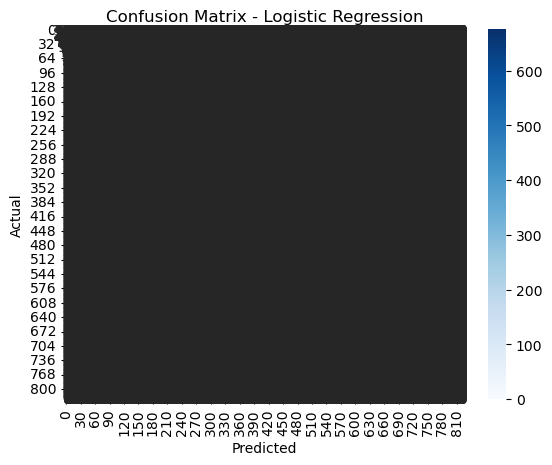

In [15]:
# Confusion Matrix for Logistic Regression
conf_matrix = confusion_matrix(y_val, y_pred_log_reg)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

I evaluate all trained models (Logistic Regression, XGBoost, and Neural Networks) on the test set and compute the required metrics.

In [16]:
# Evaluate Logistic Regression on the test set
y_pred_log_reg = log_reg.predict(X_test)
mse_log_reg = mean_squared_error(y_test, y_pred_log_reg)
mae_log_reg = mean_absolute_error(y_test, y_pred_log_reg)
r2_log_reg = r2_score(y_test, y_pred_log_reg)

print("Logistic Regression - Test Metrics:")
print(f"Mean Squared Error: {mse_log_reg}")
print(f"Mean Absolute Error: {mae_log_reg}")
print(f"R2 Score: {r2_log_reg}")

Logistic Regression - Test Metrics:
Mean Squared Error: 93094.81602733526
Mean Absolute Error: 140.65213264605813
R2 Score: 0.3809795661202251


In [17]:
# Evaluate XGBoost on the test set
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost - Test Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R2 Score: {r2_xgb}")

XGBoost - Test Metrics:
Mean Squared Error: 27810.403088985146
Mean Absolute Error: 88.12158859795302
R2 Score: 0.8150787353515625


In [18]:
# Evaluate Simple Neural Network on the test set
test_loss_simple, test_mae_simple = model_simple.evaluate(X_test, y_test)
print(f"Simple Neural Network - Test Loss (MSE): {test_loss_simple}, Test MAE: {test_mae_simple}")

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - loss: 32808.9844 - mae: 92.4318
Simple Neural Network - Test Loss (MSE): 34592.71484375, Test MAE: 92.5999984741211


In [19]:
# Evaluate Neural Network with Dropout on the test set
test_loss_dropout, test_mae_dropout = model_dropout.evaluate(X_test, y_test)
print(f"Neural Network with Dropout - Test Loss (MSE): {test_loss_dropout}, Test MAE: {test_mae_dropout}")

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 34005.8164 - mae: 95.1682
Neural Network with Dropout - Test Loss (MSE): 35492.66015625, Test MAE: 94.89520263671875


In [20]:
# Evaluate Neural Network with Dropout and L2 Regularization on the test set
test_loss_dropout_l2, test_mae_dropout_l2 = model_dropout_l2.evaluate(X_test, y_test)
print(f"Neural Network with Dropout and L2 Regularization - Test Loss (MSE): {test_loss_dropout_l2}, Test MAE: {test_mae_dropout_l2}")

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 32834.8945 - mae: 93.1307
Neural Network with Dropout and L2 Regularization - Test Loss (MSE): 34155.5, Test MAE: 92.900146484375


In [21]:
# Evaluate Neural Network with Early Stopping on the test set
test_loss_early_stopping, test_mae_early_stopping = model_early_stopping.evaluate(X_test, y_test)
print(f"Neural Network with Early Stopping - Test Loss (MSE): {test_loss_early_stopping}, Test MAE: {test_mae_early_stopping}")

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 30308.5898 - mae: 92.6573
Neural Network with Early Stopping - Test Loss (MSE): 31836.1796875, Test MAE: 92.70118713378906


Since Logistic Regression is a classification model, I computed the confusion matrix and classification metrics.

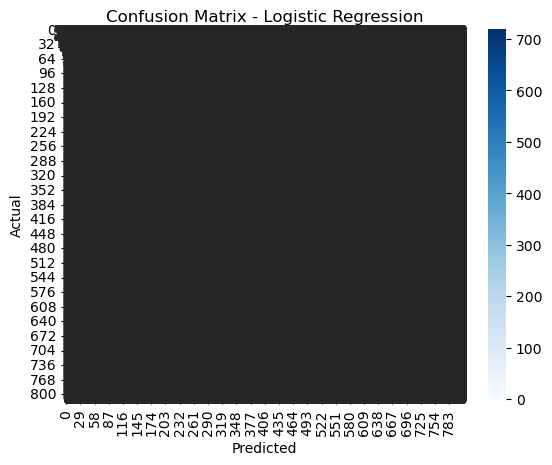

Classification Report - Logistic Regression:


c:\Users\tochi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tochi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tochi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tochi\anaconda3\Lib\site-packages\sklea

              precision    recall  f1-score   support

          13       0.12      0.39      0.18      1861
          14       0.09      0.10      0.10      1879
          15       0.11      0.14      0.13      1903
          26       0.07      0.10      0.08      1723
          27       0.07      0.07      0.07      1777
          28       0.05      0.08      0.06      1687
          40       0.04      0.05      0.05      1546
          41       0.03      0.07      0.05      1593
          42       0.03      0.05      0.04      1529
          53       0.02      0.02      0.02      1261
          54       0.03      0.03      0.03      1266
          55       0.04      0.00      0.00      1336
          67       0.03      0.04      0.03      1099
          68       0.02      0.03      0.02      1088
          69       0.04      0.04      0.04      1141
          80       0.02      0.01      0.01      1054
          81       0.01      0.01      0.01       983
          82       0.02    

In [22]:
# Confusion Matrix for Logistic Regression
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(conf_matrix_log_reg, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

In [23]:
# Save models
joblib.dump(log_reg, 'saved_models/logistic_regression.pkl')
model_simple.save('saved_models/simple_nn.h5')
model_dropout.save('saved_models/nn_with_dropout.h5')
model_dropout_l2.save('saved_models/nn_with_dropout_l2.h5')
model_early_stopping.save('saved_models/nn_with_early_stopping.h5')
joblib.dump(xgb_model, 'saved_models/xgboost.pkl')

['saved_models/xgboost.pkl']

I created a table summarizing the results of different training instances for the neural networks.

In [24]:
import pandas as pd

# Create a table summarizing training instances
results = pd.DataFrame({
    'Instance': ['Simple NN', 'NN with Dropout', 'NN with Dropout + L2', 'NN with Early Stopping'],
    'Optimizer': ['Adam', 'Adam', 'Adam', 'Adam'],
    'Regularizer': ['None', 'Dropout', 'Dropout + L2', 'Dropout + L2'],
    'Epochs': [10, 20, 30, 50],
    'Early Stopping': ['No', 'No', 'No', 'Yes'],
    'Learning Rate': [0.001, 0.001, 0.001, 0.001],
    'Test Loss (MSE)': [test_loss_simple, test_loss_dropout, test_loss_dropout_l2, test_loss_early_stopping],
    'Test MAE': [test_mae_simple, test_mae_dropout, test_mae_dropout_l2, test_mae_early_stopping]
})

print("Training Instances Table:")
print(results)

Training Instances Table:
                 Instance Optimizer   Regularizer  Epochs Early Stopping  Learning Rate  Test Loss (MSE)   Test MAE
0               Simple NN      Adam          None      10             No          0.001     34592.714844  92.599998
1         NN with Dropout      Adam       Dropout      20             No          0.001     35492.660156  94.895203
2    NN with Dropout + L2      Adam  Dropout + L2      30             No          0.001     34155.500000  92.900146
3  NN with Early Stopping      Adam  Dropout + L2      50            Yes          0.001     31836.179688  92.701187


In [25]:
# Load the best model and make predictions
from tensorflow.keras.models import load_model

best_model = load_model('saved_models/nn_with_early_stopping.h5')
predictions = best_model.predict(X_test)
print("Predictions:", predictions[:10])

2141/2141 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Predictions: [[ 61.270275]
 [218.95854 ]
 [424.33936 ]
 [269.80923 ]
 [546.2208  ]
 [ 77.07416 ]
 [308.81287 ]
 [ 59.66217 ]
 [460.01923 ]
 [174.28136 ]]
